In [1]:
import matplotlib.pyplot as plt
import torch


In [2]:
# If you have latex installed (For nice latex rendering)
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

In [3]:
def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t

def responsibilities(x, t, means, variance, weights):
    """
    Compute responsibilities r_k(x_t, t) for 1D Gaussian mixture prior.
    
    -------
    r : torch.Tensor, shape (N,K)
    """
    alpha_t, sigma_t = alpha_sigma(t)            
    var_t = sigma_t**2 + (alpha_t**2) * variance  

    x = x[:, None]
    alpha_t = alpha_t[:, None]
    var_t = var_t[:, None]
    means_t = alpha_t * means[None, :]  

    log_probs = torch.log(weights[None, :] + 1e-12) \
                - 0.5 * (torch.log(2 * torch.pi * var_t) \
                + (x - means_t)**2 / var_t)

    log_norm = torch.logsumexp(log_probs, dim=1, keepdim=True)
    r = torch.exp(log_probs - log_norm) 
    print(r)
    return r

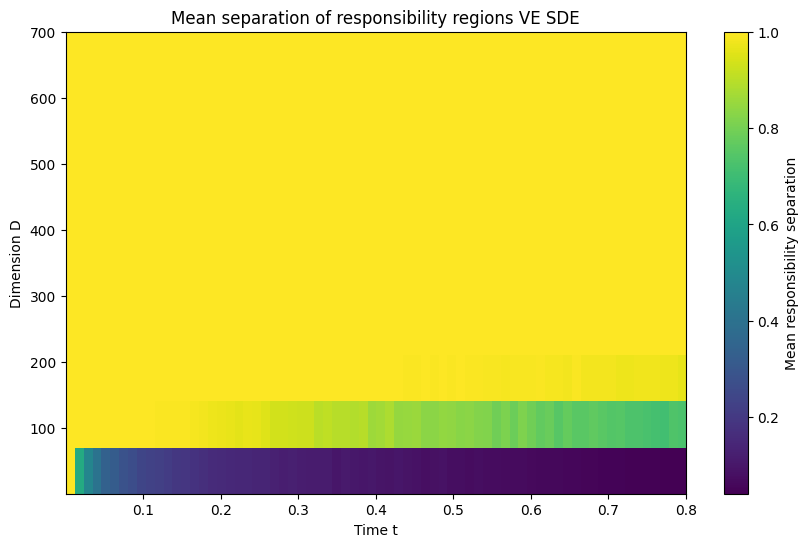

In [4]:
import torch
import matplotlib.pyplot as plt
import math

# ============================================================
# Diffusion schedule
# ============================================================


def tau(t, D, kappa=0.1, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)/ (torch.sqrt(torch.tensor(D, dtype=t.dtype, device=t.device)))
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t



def alpha_sigma(t, D, T=1.0, kappa=0.8, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, D, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t


def alpha_sigma(t, D):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def alpha_sigma(t, sigma_min=0.5, sigma_max=5, T=1.0):
    """
    Forward process parameters for a Variance-Exploding (VE) SDE
    with a *linear-in-variance* schedule.
    
    sigma_t: standard deviation at time t
    alpha_t: kept for interface consistency, but equals 1 (no drift)
    """
    # Linearly increasing variance
    sigma2_t = sigma_min**2 + (sigma_max**2 - sigma_min**2) * (t / T)
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.ones_like(t)  # no decay of mean

    return alpha_t, sigma_t


# Cosine schedule
def alpha_sigma(t, s=0.008):
    t = torch.clamp(t, 0.0, 1.0)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2
    alpha2_t = f_t / f_0
    alpha_t = torch.sqrt(alpha2_t)
    sigma_t = torch.sqrt(torch.clamp(1.0 - alpha2_t, min=0.0))
    return alpha_t, sigma_t


def alpha_sigma(t, T=1.0):
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

# ============================================================
# Responsibilities
# ============================================================

def responsibilities_full(x, t, means, variances, weights, D):
    N, D = x.shape
    K = means.shape[0]
    alpha_t, sigma_t = alpha_sigma(t,D)

    alpha_t = torch.as_tensor(alpha_t, device=x.device, dtype=x.dtype)
    sigma_t = torch.as_tensor(sigma_t, device=x.device, dtype=x.dtype)

    means_t = alpha_t * means
    var_t = sigma_t**2 + (alpha_t**2) * variances

    diffs = x[:, None, :] - means_t[None, :, :]
    log_probs = torch.log(weights[None, :] + 1e-12) \
                - 0.5 * (D * torch.log(2 * torch.pi * var_t[None, :])
                         + (diffs**2).sum(dim=2) / var_t[None, :])

    log_norm = torch.logsumexp(log_probs, dim=1, keepdim=True)
    r = torch.exp(log_probs - log_norm)
    return r

# ============================================================
# Parameters
# ============================================================

device = "cpu"
torch.manual_seed(0)

weights = torch.tensor([0.5, 0.5], device=device)
variances = torch.tensor([0.00005, 0.00005], device=device)
T = 0.8
n_times = 70
times = torch.linspace(1e-6, T, n_times, device=device)
N = 600
LAMBDA_MIN, LAMBDA_MAX = -20, 20 #min/max logSNR values #-20,20#min/max logSNR values #-20,20

# Dimensions to test
dims = [1,10,20, 100,150,200, 300,400,500, 700]

# ============================================================
# Compute mean separation heatmap
# ============================================================

heatmap = torch.zeros(len(dims), n_times)

for i, D in enumerate(dims):
    means = torch.tensor([[-0.1]*D, [0.1]*D], device=device)
    for j, t_val in enumerate(times):
        t = t_val.clone().detach()
        # sample from mixture
        comp_idx = torch.multinomial(weights, N, replacement=True)
        x0 = torch.randn(N, D, device=device) * torch.sqrt(variances[comp_idx])[:, None] + means[comp_idx]

        # forward diffusion
        alpha_t, sigma_t = alpha_sigma(t, D)
        eps = torch.randn_like(x0)
        x_t = alpha_t * x0 + sigma_t * eps

        # responsibilities
        r = responsibilities_full(x_t, t, means, variances, weights, D)

        # mean separation between two components
        sep = torch.abs(r[:, 0] - r[:, 1]).mean().item()
        heatmap[i, j] = sep

# ============================================================
# Plot heatmap
# ============================================================

plt.figure(figsize=(10, 6))
plt.imshow(
    heatmap.cpu().numpy(),
    extent=[times.min(), times.max(), dims[0], dims[-1]],
    origin="lower",
    aspect="auto",
    cmap='viridis'
)
plt.colorbar(label="Mean responsibility separation")
plt.xlabel("Time t")
plt.ylabel("Dimension D")
plt.title("Mean separation of responsibility regions VE SDE")
plt.show()



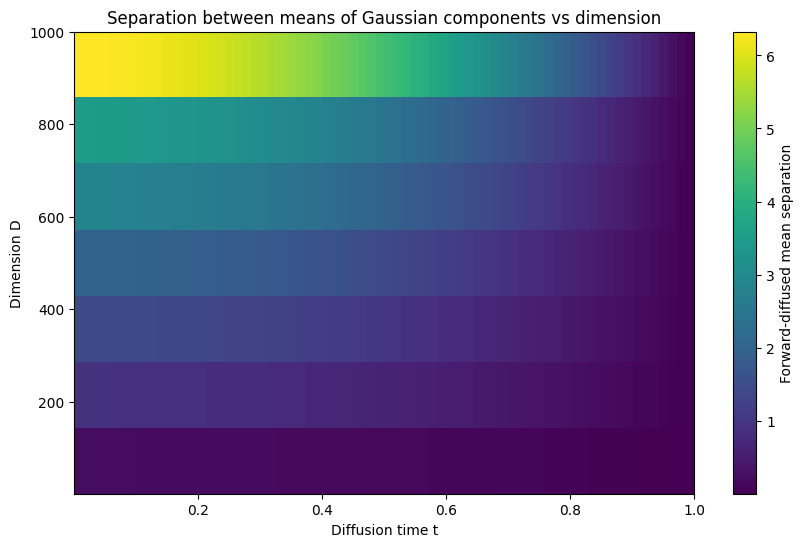

In [13]:
import torch
import matplotlib.pyplot as plt
import math

# ============================================================
# Parameters
# ============================================================
device = "cpu"

dims = [1,20,50,100,200,300,1000]
n_times = 70
T = 1
times = torch.linspace(1e-6, T, n_times, device=device)

# Gaussian means
delta_per_dim = 0.1  # per-dimension difference
# mu1 = [-delta, -delta, ..., -delta], mu2 = [delta, delta, ..., delta]

# ============================================================
# Diffusion schedule (cosine)
# ============================================================
def alpha_sigma(t, s=0.008):
    t = torch.clamp(t, 0.0, 1.0)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2
    alpha2_t = f_t / f_0
    alpha_t = torch.sqrt(alpha2_t)
    return alpha_t

# ============================================================
# Compute forward-diffused mean separation
# ============================================================
heatmap = torch.zeros(len(dims), n_times)

for i, D in enumerate(dims):
    # Euclidean distance between original means
    R0 = torch.norm(torch.full((D,), -delta_per_dim) - torch.full((D,), delta_per_dim))
    for j, t_val in enumerate(times):
        alpha_t = alpha_sigma(t_val)
        # Forward-diffused mean separation
        R_t = alpha_t * R0
        heatmap[i, j] = R_t.item()

# ============================================================
# Plot heatmap
# ============================================================
plt.figure(figsize=(10, 6))
plt.imshow(
    heatmap.cpu().numpy(),
    extent=[times.min(), times.max(), dims[0], dims[-1]],
    origin="lower",
    aspect="auto",
    cmap='viridis'
)
plt.colorbar(label="Forward-diffused mean separation")
plt.xlabel("Diffusion time t")
plt.ylabel("Dimension D")
plt.title("Separation between means of Gaussian components vs dimension")
plt.show()


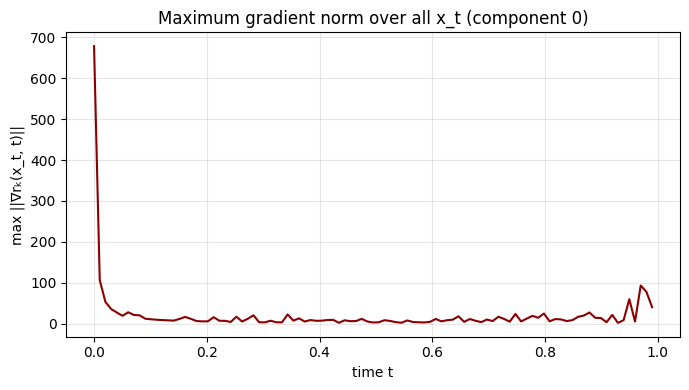

(tensor([1.0000e-06, 1.0102e-02, 2.0203e-02, 3.0304e-02, 4.0405e-02, 5.0506e-02,
         6.0607e-02, 7.0708e-02, 8.0809e-02, 9.0910e-02, 1.0101e-01, 1.1111e-01,
         1.2121e-01, 1.3131e-01, 1.4141e-01, 1.5152e-01, 1.6162e-01, 1.7172e-01,
         1.8182e-01, 1.9192e-01, 2.0202e-01, 2.1212e-01, 2.2222e-01, 2.3232e-01,
         2.4242e-01, 2.5253e-01, 2.6263e-01, 2.7273e-01, 2.8283e-01, 2.9293e-01,
         3.0303e-01, 3.1313e-01, 3.2323e-01, 3.3333e-01, 3.4344e-01, 3.5354e-01,
         3.6364e-01, 3.7374e-01, 3.8384e-01, 3.9394e-01, 4.0404e-01, 4.1414e-01,
         4.2424e-01, 4.3434e-01, 4.4445e-01, 4.5455e-01, 4.6465e-01, 4.7475e-01,
         4.8485e-01, 4.9495e-01, 5.0505e-01, 5.1515e-01, 5.2525e-01, 5.3535e-01,
         5.4545e-01, 5.5556e-01, 5.6566e-01, 5.7576e-01, 5.8586e-01, 5.9596e-01,
         6.0606e-01, 6.1616e-01, 6.2626e-01, 6.3636e-01, 6.4647e-01, 6.5657e-01,
         6.6667e-01, 6.7677e-01, 6.8687e-01, 6.9697e-01, 7.0707e-01, 7.1717e-01,
         7.2727e-01, 7.3737e

In [27]:
import torch
import matplotlib.pyplot as plt

# ============================================================
# Diffusion schedule
# ============================================================
def alpha_sigma(t, T=1.0):
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t


# ============================================================
# Responsibilities for high-dimensional Gaussian mixture
# ============================================================
def responsibilities(x, t, means, variances, weights):
    """
    x: (N, D)
    t: scalar tensor
    means: (K, D)
    variances: (K,)
    weights: (K,)
    returns: r(x_t, t) shape (N, K)
    """
    alpha_t, sigma_t = alpha_sigma(t)
    var_t = sigma_t**2 + (alpha_t**2) * variances  # (K,)
    means_t = alpha_t * means                      # (K, D)

    x_exp = x[:, None, :]  # (N, 1, D)
    means_exp = means_t[None, :, :]  # (1, K, D)
    var_exp = var_t[None, :, None]   # (1, K, 1)

    log_probs = torch.log(weights[None, :] + 1e-12) \
                - 0.5 * (torch.sum((x_exp - means_exp)**2 / var_exp, dim=-1)
                         + x.shape[1] * torch.log(2 * torch.pi * var_t[None, :]))

    log_norm = torch.logsumexp(log_probs, dim=1, keepdim=True)
    r = torch.exp(log_probs - log_norm)
    return r


# ============================================================
# Compute max gradient norm across all samples, for one component
# ============================================================
def max_gradient_vs_time(D=10, K=2, N=512, n_times=100, target_k=0, device="cpu"):
    torch.manual_seed(0)
    T = 1.0
    times = torch.linspace(1e-6, T, n_times, device=device)

    # two delta-like components
    means = torch.tensor([[-0.5]*D, [0.5]*D], device=device)
    variances = torch.full((K,), 0.0005, device=device)
    weights = torch.ones(K, device=device) / K

    x0 = torch.randn(N, D, device=device)
    max_gradients = []

    for t in times:
        alpha_t, sigma_t = alpha_sigma(t)
        eps = torch.randn_like(x0)
        x_t = alpha_t * x0 + sigma_t * eps
        x_t.requires_grad_(True)

        # Make t a differentiable scalar
        t_var = t.clone().detach().requires_grad_(True)

        r = responsibilities(x_t, t_var, means, variances, weights)[:, target_k]

        grad_x, grad_t = torch.autograd.grad(
            outputs=r,
            inputs=(x_t, t_var),
            grad_outputs=torch.ones_like(r),
            create_graph=False,
            retain_graph=False
        )

        # Compute combined gradient norm per sample
        grad_norm = torch.sqrt(grad_x.pow(2).sum(dim=1) + grad_t.pow(2))
        max_grad = grad_norm.max().item()
        max_gradients.append(max_grad)

    max_gradients = torch.tensor(max_gradients)

    # Plot results
    plt.figure(figsize=(7, 4))
    plt.plot(times.cpu(), max_gradients.cpu(), color="darkred")
    plt.xlabel("time t")
    plt.ylabel("max ||∇rₖ(x_t, t)||")
    plt.title(f"Maximum gradient norm over all x_t (component {target_k})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return times, max_gradients


# ============================================================
# Run it
# ============================================================
max_gradient_vs_time(D=20, target_k=0)


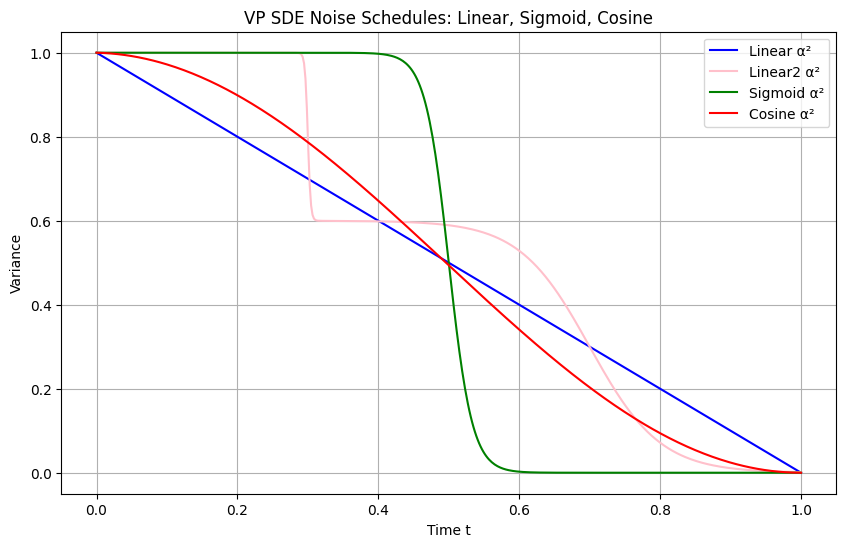

In [2]:
import torch
import matplotlib.pyplot as plt
import math

# Define time vector
t = torch.linspace(0, 1, 500)

# Linear-in-noise-variance schedule
def linear_alpha_sigma(t, T=1.0):
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t


def tau(t, kappa=0.5, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def linear_alpha_sigma_tau(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

import torch


def double_plateau_alpha_sigma(t, centers=(0.3, 0.7), sharpness=(500, 20), levels=(1.0, 0.6, 0)):
    """
    Variance-preserving schedule where alpha_t has three plateaus and two sharp drops.

    Args:
        t: torch.tensor in [0, 1]
        centers: positions of the two drops (c1, c2)
        sharpness: steepness of each drop (k1, k2)
        levels: plateau values of alpha (alpha_early, alpha_mid, alpha_late)
    Returns:
        alpha_t, sigma_t
    """
    c1, c2 = centers
    k1, k2 = sharpness
    a1, a2, a3 = levels

    # Two logistic transitions between plateaus
    s1 = torch.sigmoid(-k1 * (t - c1))  # from 1 → 0 at c1
    s2 = torch.sigmoid(-k2 * (t - c2))  # from 1 → 0 at c2

    # Combine transitions to create flat–drop–flat–drop–flat pattern
    alpha_t = a3 + (a2 - a3) * s2 + (a1 - a2) * s1

    # Variance preserving
    sigma_t = torch.sqrt(1 - alpha_t**2)
    return alpha_t, sigma_t



def linear2_alpha_sigma(t, T=1.0):
    sigma2_t = (t**2) / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

# Sigmoid/log-SNR-linear schedule
def sigmoid_alpha_sigma(t, lambda_min=-30, lambda_max=30):
    lambda_t = lambda_max + (lambda_min - lambda_max) * t
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def sigmoid_alpha_sigma_2t(t, lambda_min=-10, lambda_max=10):
    lambda_t = lambda_max + (lambda_min - lambda_max) * 2*t
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

# Cosine schedule
def cosine_alpha_sigma(t, s=0.008):
    t = torch.clamp(t, 0.0, 1.0)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2
    alpha2_t = f_t / f_0
    alpha_t = torch.sqrt(alpha2_t)
    sigma_t = torch.sqrt(torch.clamp(1.0 - alpha2_t, min=0.0))
    return alpha_t, sigma_t

# Compute alpha and sigma for all schedules
alpha_lin, sigma_lin = linear_alpha_sigma(t)
alpha_lin2, sigma_lin2 = linear2_alpha_sigma(t)
alpha_tau, sigma_tau = linear_alpha_sigma_tau(t)
alpha_d, sigma_d = double_plateau_alpha_sigma(t)


alpha_sig, sigma_sig = sigmoid_alpha_sigma(t)
alpha_cos, sigma_cos = cosine_alpha_sigma(t)
alpha_cos2, sigma_cos2 = sigmoid_alpha_sigma_2t(t)

# Plot alpha^2 (signal) and sigma^2 (noise) for each schedule
plt.figure(figsize=(10,6))
plt.plot(t, alpha_lin**2, label='Linear α²', color='blue')
plt.plot(t, alpha_d, label='Linear2 α²', color='pink')
#plt.plot(t, alpha_tau, label='Linear tau α²', color='black')

#plt.plot(t, sigma_lin**2, label='Linear σ²', color='blue', linestyle='--')
plt.plot(t, alpha_sig**2, label='Sigmoid α²', color='green')
#plt.plot(t, sigma_sig**2, label='Sigmoid σ²', color='green', linestyle='--')
plt.plot(t, alpha_cos**2, label='Cosine α²', color='red')
#plt.plot(t, alpha_cos2**2, label='2t sigmoid²', color='orange')

#plt.plot(t, sigma_cos**2, label='Cosine σ²', color='red', linestyle='--')
plt.xlabel('Time t')
plt.ylabel('Variance')
plt.title('VP SDE Noise Schedules: Linear, Sigmoid, Cosine')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1000/1000 [00:03<00:00, 285.81it/s]


If the data distribution $p_0$ is a Gaussian Mixture, then the denoising distribution $p(x_0\mid x_t)$ is also a Gaussian mixture.

Specifically, if $p_0 = \sum_i \pi_i \mathcal{N}(\mu_i, \sigma^2I)$, and $p_{t|0}(x_t\mid x_0) = \mathcal{N}(x_t\mid \alpha_tx_0, \sigma_t^2I)$, then

$$p_{0|t}(x_0\mid x_t) = \frac{p_0(x_0)p_{t|0}(x_t\mid x_0)}{p_t(x_t)} = \sum_i \pi_i \mathcal{N}(x_0\mid\tilde{\mu}_i, \tilde{\sigma}_t^2I),$$
where
\begin{align}
\tilde{\sigma}_t^2 &= \left( \frac{1}{\sigma^2} + \frac{\alpha_t^2}{\sigma_t^2} \right)^{-1} \\
\tilde{\mu}_i & = \tilde{\sigma}_t^2 \left( \frac{\mu_i}{\sigma^2} + \frac{\alpha_t^2}{\sigma_t^2}x_t  \right)
\end{align}

In [5]:
from gm_utils import get_means_and_variances # Implementation of the above means and variance for the denoising Gaussian mixture

In [62]:
import torch
from gm_utils import geodesic

def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

theta1 = torch.tensor([0.2, -2.]) #(theta=(t, x))
theta2 = torch.tensor([0.3, 0])

LAMBDA_MIN, LAMBDA_MAX = -20, 20 #min/max logSNR values #-20,20#min/max logSNR values #-20,20


num_discretization_points = 5000
num_optimization_steps = 1000

shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points)

100%|██████████| 1000/1000 [00:31<00:00, 31.63it/s]


In [49]:
import numpy as np
from gm_utils import visualize_density


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)

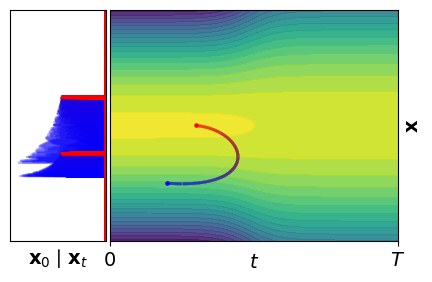

In [63]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm

#from gm_utils import weights

fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

original_means = torch.tensor([-1, 1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.00002, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)  #[0.4, 0.4, 0.2]

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

# Local version of get_means_and_variances using our local variables
def get_local_means_and_variances(t, x, means, variance):
    """Local version using our defined means and variance"""
    alpha, sigma = alpha_sigma(t)
    snr = (alpha/sigma) ** 2  # signal to noise ratio
    variance_inv = 1 / variance + snr
    variance_new = 1 / variance_inv
    means_new = means/variance + alpha/sigma ** 2 * x
    return (means_new * variance_new).numpy(), variance_new.numpy()

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    # Use our local function with our local variables
    mean, var = get_local_means_and_variances(theta[0], theta[1], original_means, original_variance)
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)

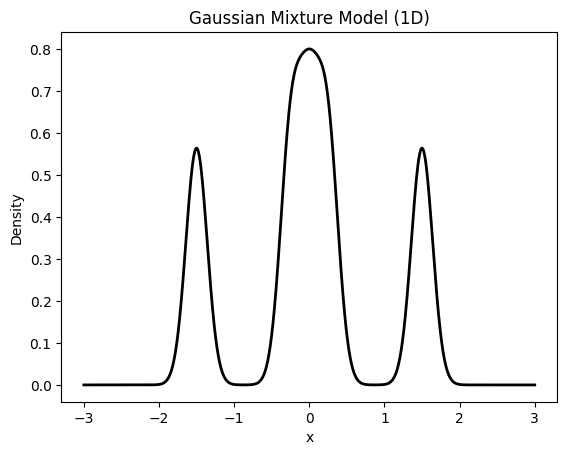

In [30]:
import torch
import matplotlib.pyplot as plt

original_means = torch.tensor([ -1.5, -0.25, 0, 0.25, 1.5], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.02, dtype=torch.float32) #0.4
weights = torch.tensor([1/5, 1/5, 1/5, 1/5, 1/5], dtype=torch.float32)  #[0.4, 0.4, 0.2]

original_std = torch.sqrt(original_variance)
x = torch.linspace(-3, 3, 1000)

# Constant as tensor
pi = torch.tensor(torch.pi)

# Gaussian PDF function
def gaussian_pdf(x, mean, std):
    return (1.0 / (torch.sqrt(2 * pi) * std)) * torch.exp(-0.5 * ((x - mean) / std) ** 2)

# Compute mixture PDF
component_pdfs = torch.stack([gaussian_pdf(x, m, original_std) for m in original_means])
mixture_pdf = torch.sum(weights[:, None] * component_pdfs, dim=0)


plt.plot(x, mixture_pdf, color='k', linewidth=2, label='Mixture PDF')

plt.title("Gaussian Mixture Model (1D)")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(False)
plt.show()

